# 1. Introduction

New York City is the most populous city in the United States, home to the headquarters of the United Nations and an important center for international diplomacy. It just might be the most diverse city on the planet, as it is home to over 8.6 million people and over 800 languages.
Undoubtedly, Food Diversity is an important part of an ethnically diverse metropolis. The idea of this project is to categorically segment the neighborhoods of New York City into major clusters and examine their cuisines. A desirable intention is to examine the neighborhood cluster's food habits and taste. Further examination might reveal if food has any relationship with the diversity of a neighborhood.This project will help to understand the diversity of a neighborhood by leveraging venue data from Foursquare’s ‘Places API’ and ‘k-means clustering’ machine learning algorithm.

# 2. Data

# 2. Methodology

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pprint import pprint # data pretty printer

import requests # library to handle requests
from bs4 import BeautifulSoup  # library to handle web scraping

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from collections import Counter # count occurrences 

from sklearn.cluster import KMeans # import k-means from clustering stage


Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    altair-4.0.0               |             py_0         606 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be 

# Download and Explore New York City Dataset

In [2]:
!pip install wget
import wget
import os

if os.path.exists('newyork_data.json'):
    os.remove('newyork_data.json')

wget.download('https://cocl.us/new_york_dataset/newyork_data.json')

print('\nData downloaded!')





  Stored in directory: /home/dsxuser/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    


In [4]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

In [5]:
print ("newyork_data key and value's length are: ") 
for key, value in newyork_data.items(): 
    print (key, len(str(value)))

newyork_data key and value's length are: 
type 17
totalFeatures 3
features 124743
crs 70
bbox 74


All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data

In [6]:
neighborhoods_data = newyork_data['features']
pprint(neighborhoods_data[305])

{'geometry': {'coordinates': [-74.08173992211962, 40.61731079252983],
              'type': 'Point'},
 'geometry_name': 'geom',
 'id': 'nyu_2451_34572.306',
 'properties': {'annoangle': 0.0,
                'annoline1': 'Fox',
                'annoline2': 'Hills',
                'annoline3': None,
                'bbox': [-74.08173992211962,
                         40.61731079252983,
                         -74.08173992211962,
                         40.61731079252983],
                'borough': 'Staten Island',
                'name': 'Fox Hills',
                'stacked': 2},
 'type': 'Feature'}


Tranform the data into a pandas dataframe

In [7]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [8]:
for data in neighborhoods_data:
    borough = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [9]:
neighborhoods.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [10]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of New York City.

In [11]:
address = 'New York City, NY'
location = None

# define an instance of the geocoder -> ny_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="ny_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map of New York with neighborhoods superimposed on top.

In [12]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork


Define Foursquare Credentials and Version
Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [23]:
CLIENT_ID = 'KP4M0E0VCRN4C3AFBPPCH32GWOQYPHJDDW3XDOZBGJAFD4YH'# your Foursquare ID
CLIENT_SECRET = 'RHYP0UTRKQJRFJH3AI3OPNKCCPT4U2XQ5MQAYY3VC3M5KV1U' #your Foursquare Secret
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KP4M0E0VCRN4C3AFBPPCH32GWOQYPHJDDW3XDOZBGJAFD4YH
CLIENT_SECRET:RHYP0UTRKQJRFJH3AI3OPNKCCPT4U2XQ5MQAYY3VC3M5KV1U


Fetch Foursquare Venue Category Hierarchy

In [25]:
url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
category_results = requests.get(url).json()

In [26]:
for key, value in category_results['response']['categories'][0].items():
    print(key, len(str(value)))

id 24
name 20
pluralName 20
shortName 20
icon 98
categories 15910


In [27]:
category_list = category_results['response']['categories']

In [28]:
len(category_list)

10

In [29]:
for data in category_list:
    print(data['id'], data['name'])

4d4b7104d754a06370d81259 Arts & Entertainment
4d4b7105d754a06372d81259 College & University
4d4b7105d754a06373d81259 Event
4d4b7105d754a06374d81259 Food
4d4b7105d754a06376d81259 Nightlife Spot
4d4b7105d754a06377d81259 Outdoors & Recreation
4d4b7105d754a06375d81259 Professional & Other Places
4e67e38e036454776db1fb3a Residence
4d4b7105d754a06378d81259 Shop & Service
4d4b7105d754a06379d81259 Travel & Transport


Food & It's Sub-Categories

Let's create a function to return a dictionary with Ids' & Names of Food & It's Sub-Categories.

In [30]:
# function to flatten a 'parent_id' category, returns all categories if checkParentID = False
def flatten_Hierarchy(category_list, checkParentID, category_dict, parent_id = ''):
    for data in category_list:
        
        if checkParentID == True and data['id'] == parent_id:
            category_dict[data['id']] = data['name']
            flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
        
        elif checkParentID == False:
            category_dict[data['id']] = data['name']
            if len(data['categories']) != 0:
                flatten_Hierarchy(category_list = data['categories'], checkParentID = False, category_dict = category_dict)
    
    return category_dict

In [31]:
# this function takes the parent ID and returns 'name' and 'id' of all the sub-categories
category_dict = flatten_Hierarchy(category_list, checkParentID=True, category_dict = {}, parent_id = '4d4b7105d754a06374d81259')

Now, we have all the categories in Food with their id's.

Explore the first neighborhood to understand the results of GET Request
Get the neighborhood's name.

In [32]:
neighborhoods.loc[0, 'Neighborhood']

'Wakefield'

Get the neighborhood's latitude and longitude values.

In [33]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Wakefield are 40.89470517661, -73.84720052054902.


Now, let's get the Food that is in Wakefield within a radius of 500 meters.¶
First, let's create the GET request URL to search for Venue with requested Category ID

In [34]:
LIMIT = 1 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = '4d4b7105d754a06374d81259' # category ID for "Food"

# create URL

url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius,
    categoryId,
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/search?&client_id=KP4M0E0VCRN4C3AFBPPCH32GWOQYPHJDDW3XDOZBGJAFD4YH&client_secret=RHYP0UTRKQJRFJH3AI3OPNKCCPT4U2XQ5MQAYY3VC3M5KV1U&v=20180605&ll=40.89470517661,-73.84720052054902&radius=500&categoryId=4d4b7105d754a06374d81259&limit=1'

Send the GET request and examine the resutls

In [35]:
results = requests.get(url).json()

In [36]:
results['response']['venues']

[{'id': '4c783cef3badb1f7e4244b54',
  'name': 'Carvel Ice Cream',
  'location': {'address': '1006 E 233rd St',
   'lat': 40.890486685759605,
   'lng': -73.84856772568665,
   'labeledLatLngs': [{'label': 'display',
     'lat': 40.890486685759605,
     'lng': -73.84856772568665}],
   'distance': 483,
   'postalCode': '10466',
   'cc': 'US',
   'city': 'Bronx',
   'state': 'NY',
   'country': 'United States',
   'formattedAddress': ['1006 E 233rd St',
    'Bronx, NY 10466',
    'United States']},
  'categories': [{'id': '4bf58dd8d48988d1c9941735',
    'name': 'Ice Cream Shop',
    'pluralName': 'Ice Cream Shops',
    'shortName': 'Ice Cream',
    'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/icecream_',
     'suffix': '.png'},
    'primary': True}],
  'referralId': 'v-1578151140',
  'hasPerk': False}]

The category name of the venue 'Carvel Ice Cream' is 'Food'.

As, our aim is to segment the neighborhoods of NYC with respect to the Food in its vicinity. We need to proceed further to fetch this data from all the 306 neighborhoods' venues.

Let's create a function to repeat the following process to all the neighborhoods in NYC:
Loop through neighborhoods
Create the API request URL with radius=500, LIMIT=100
Make the GET request
For each neighborhood, return only relevant information for each nearby venue
Append all nearby venues to a list
Unfold the list & append it to dataframe being returned
The categoryId parameter in the API request URL can be a comma seperated string. So, lets create a comma seperated string from category_dict.

In [37]:
categoryId_list = []
for key, value in category_dict.items():
    categoryId_list.append(key)
categoryId = ','.join(categoryId_list)

The above process turns out to be redundant because if a top-level category is specified in the GET Request, all sub-categories will also match the query. But it is an interesting way to retrieve all the sub-categories ID with name

In [39]:
def getNearbyFood(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            "4d4b7105d754a06374d81259", # "Food" category id
            LIMIT)
            
        try:
            # make the GET request
            results = requests.get(url).json()['response']['venues']
            
            # return only relevant information for each nearby venue
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name']) for v in results])
        except:
            not_found += 1


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)          
    

Let's use pickle library to serialize the information retrieved from GET requests. This step will counter any redundant requests to the Foursquare API.

In [40]:
import pickle # to serialize and deserialize a Python object structure
try:
    with open('nyc_food_venues.pkl', 'rb') as f:
        nyc_venues = pickle.load(f)
    print("---Dataframe Existed and Deserialized---")
except:
    nyc_venues = getNearbyFood(names=neighborhoods['Neighborhood'],
                                        latitudes=neighborhoods['Latitude'],
                                        longitudes=neighborhoods['Longitude']
                                       )
    with open('nyc_food_venues.pkl', 'wb') as f:
        pickle.dump(nyc_venues, f)
    print("---Dataframe Created and Serialized---")

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.
---Dataframe Created and Serialized---


# 3. Analysis & Machine Learning

Let's check the size of the resulting dataframe

In [41]:
print(nyc_venues.shape)
nyc_venues.head()

(13983, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,40.894705,-73.847201,McDonald's,40.902645,-73.849485,Fast Food Restaurant
2,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop
3,Wakefield,40.894705,-73.847201,Dunkin',40.893064,-73.856977,Donut Shop
4,Wakefield,40.894705,-73.847201,Margaritaville Restaurant and Lounge,40.898564,-73.837016,Caribbean Restaurant


Let's find out how many unique categories can be curated from all the returned venues

In [42]:
print('There are {} uniques categories.'.format(len(nyc_venues['Venue Category'].unique())))
nyc_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 197 uniques categories.


Venue Category
Deli / Bodega                               1064
Pizza Place                                 1037
Coffee Shop                                  896
Donut Shop                                   662
Chinese Restaurant                           647
Fast Food Restaurant                         638
Italian Restaurant                           563
Bakery                                       557
American Restaurant                          431
Café                                         385
Bagel Shop                                   369
Caribbean Restaurant                         357
Mexican Restaurant                           343
Sandwich Place                               303
Diner                                        291
Fried Chicken Joint                          283
Restaurant                                   230
Ice Cream Shop                               218
Food                                         202
Burger Joint                                 168
Food 

In [43]:
# list all the categories
unique_categories = nyc_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Dessert Shop, Fast Food Restaurant, Donut Shop, Caribbean Restaurant, Comfort Food Restaurant, Food Truck, Food, Restaurant, Ice Cream Shop, Deli / Bodega, Bagel Shop, Southern / Soul Food Restaurant, Chinese Restaurant, American Restaurant, Pizza Place, Steakhouse, Fried Chicken Joint, Seafood Restaurant, Bakery, Dumpling Restaurant, Coffee Shop, Mexican Restaurant, Frozen Yogurt Shop, Spanish Restaurant, Sandwich Place, BBQ Joint, Italian Restaurant, Burger Joint, Diner, Breakfast Spot, Grocery Store, Juice Bar, Café, Wings Joint, Asian Restaurant, Latin American Restaurant, Sushi Restaurant, Tapas Restaurant, Greek Restaurant, Japanese Restaurant, Bar, Indian Restaurant, Empanada Restaurant, Vegetarian / Vegan Restaurant, New American Restaurant, Cuban Restaurant, Thai Restaurant, Lounge, Pub, Irish Pub, Fish & Chips Shop, Taco Place, Gas Station, Cafeteria, Soup Place, Other Nightlife, Arcade, Hot Dog Joint, Snack Place, Food Court, French Restaurant, Convenience Store, Food & Drin

In [44]:
# manually create a list of generalized categories
general_categories = ['Dessert Shop','Food','Ice Cream Shop','Donut Shop','Bakery','Sandwich Place','Comfort Food Restaurant',
                    'Deli / Bodega','Food Truck','Bagel Shop','Burger Joint','Restaurant','Frozen Yogurt Shop','Coffee Shop',
                    'Diner','Wings Joint','Café','Juice Bar','Breakfast Spot','Grocery Store','Bar','Cupcake Shop',
                    'Pub','Fish & Chips Shop','Cafeteria','Other Nightlife','Arcade','Hot Dog Joint','Food Court',
                    'Health Food Store','Convenience Store','Food & Drink Shop','Cocktail Bar','Cheese Shop',
                    'Snack Place','Sports Bar','Lounge','Theme Restaurant','Buffet','Bubble Tea Shop','Building',
                    'Irish Pub','College Cafeteria','Tea Room','Supermarket','Hotpot Restaurant','Gastropub','Beer Garden',
                    'Fish Market','Beer Bar','Clothing Store','Music Venue','Bistro','Salad Place','Wine Bar','Gourmet Shop',
                    'Indie Movie Theater','Art Gallery','Gift Shop','Pie Shop','Fruit & Vegetable Store',
                    'Street Food Gathering','Dive Bar','Factory','Farmers Market','Mac & Cheese Joint','Creperie',
                    'Candy Store','Event Space','Skating Rink','Miscellaneous Shop','Gas Station','Organic Grocery',
                    'Pastry Shop','Club House','Flea Market','Hotel','Furniture / Home Store','Bookstore','Pet Café',
                    'Gym / Fitness Center','Flower Shop','Financial or Legal Service','Hotel Bar','Hookah Bar','Poke Place',
                    'Market','Gluten-free Restaurant','Smoothie Shop','Butcher','Food Stand','Beach Bar','Beach',
                    'Soup Place','Rock Club','Residential Building (Apartment / Condo)','Laundry Service',
                    'Government Building','Bowling Alley','Nightclub','Park','Moving Target']

In [45]:
# fetch all the required food categories
food_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in food_categories))

Tapas Restaurant, Taco Place, Soba Restaurant, Paella Restaurant, Fast Food Restaurant, English Restaurant, Sri Lankan Restaurant, Australian Restaurant, Jazz Club, Dosa Place, Tex-Mex Restaurant, Salvadoran Restaurant, Dutch Restaurant, Greek Restaurant, Himalayan Restaurant, Italian Restaurant, Indian Chinese Restaurant, Turkish Restaurant, Modern European Restaurant, Caribbean Restaurant, Hawaiian Restaurant, Latin American Restaurant, Tibetan Restaurant, Falafel Restaurant, Souvlaki Shop, South American Restaurant, Thai Restaurant, Speakeasy, Southern / Soul Food Restaurant, Taiwanese Restaurant, Dim Sum Restaurant, Cuban Restaurant, Kebab Restaurant, Steakhouse, Chinese Restaurant, Sushi Restaurant, Burrito Place, French Restaurant, Food Service, African Restaurant, Cajun / Creole Restaurant, Austrian Restaurant, Burmese Restaurant, Shabu-Shabu Restaurant, Varenyky restaurant, Chocolate Shop, Empanada Restaurant, Indian Restaurant, Persian Restaurant, Office, Seafood Restaurant, R

Let's remove all the generalized categories, like Coffee Shop, Cafe, etc

In [46]:
nyc_venues = nyc_venues[nyc_venues['Venue Category'].isin(food_categories)].reset_index()
nyc_venues.head(5)

,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,Wakefield,40.894705,-73.847201,McDonald's,40.902645,-73.849485,Fast Food Restaurant
1,4,Wakefield,40.894705,-73.847201,Margaritaville Restaurant and Lounge,40.898564,-73.837016,Caribbean Restaurant
2,5,Wakefield,40.894705,-73.847201,Paul's Caribbean Bakery,40.899774,-73.857177,Caribbean Restaurant
3,7,Wakefield,40.894705,-73.847201,Golden Krust Caribbean Restaurant,40.903773,-73.850051,Caribbean Restaurant
4,8,Wakefield,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,40.898083,-73.850259,Caribbean Restaurant


In [47]:
print('There are {} unique FOOD categories.'.format(len(nyc_venues['Venue Category'].unique())))

There are 101 unique FOOD categories.


let's find out how many unique venues can be curated from all the returned venues¶

In [48]:
print('There are {} uniques venues.'.format(len(nyc_venues['Venue'].unique())))

There are 3380 uniques venues.


# Analyze Each Neighborhood¶

In [49]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 
nyc_onehot.head()

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar,Neighborhood
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Wakefield


In [51]:
# move neighborhood column to the first column
Neighborhood = nyc_onehot['Neighborhood']

nyc_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
nyc_onehot.insert(0, 'Neighborhood', Neighborhood)

nyc_onehot.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


And let's examine the new dataframe size.

In [52]:
nyc_onehot.shape

(6965, 102)

Let's count venues of each category in each neighborhood

In [53]:
venue_counts = nyc_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
Neighborhood,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allerton,0,0,1,0,0,0,0,0,0,0,0,0,0,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Annadale,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arden Heights,0,0,3,0,0,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arlington,0,0,2,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,1,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arrochar,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


Let's find out the top 10 food categories in NYC

In [54]:
venue_counts_described = venue_counts.describe().transpose()

In [55]:
venue_top10 = venue_counts_described.sort_values('max', ascending=False)[0:10]
venue_top10

,count,mean,std,min,25%,50%,75%,max
Korean Restaurant,302.0,0.334437,1.959068,0.0,0.0,0.0,0.0,30.0
Caribbean Restaurant,302.0,1.182119,2.664510,0.0,0.0,0.0,1.0,18.0
Italian Restaurant,302.0,1.864238,2.160837,0.0,0.0,1.0,3.0,14.0
Chinese Restaurant,302.0,2.142384,1.997405,0.0,1.0,2.0,3.0,14.0
Indian Restaurant,302.0,0.278146,0.930537,0.0,0.0,0.0,0.0,12.0
Fast Food Restaurant,302.0,2.112583,1.949676,0.0,1.0,2.0,3.0,10.0
Pizza Place,302.0,3.433775,2.015039,0.0,2.0,3.0,5.0,9.0
Seafood Restaurant,302.0,0.526490,0.861290,0.0,0.0,0.0,1.0,8.0
Latin American Restaurant,302.0,0.460265,0.993372,0.0,0.0,0.0,1.0,7.0
Mexican Restaurant,302.0,1.135762,1.186068,0.0,0.0,1.0,2.0,6.0


In [56]:
venue_top10_list = venue_top10.index.values.tolist()

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(5, 2, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top10_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:10]
    pal = sns.color_palette("Blues", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

<Figure size 2000x2000 with 10 Axes>

In [ ]:
Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [58]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped.head()

,Neighborhood,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Austrian Restaurant,BBQ Joint,Brazilian Restaurant,Burmese Restaurant,Burrito Place,Cajun / Creole Restaurant,Cantonese Restaurant,Caribbean Restaurant,Chinese Restaurant,Chocolate Shop,Colombian Restaurant,Cuban Restaurant,Dim Sum Restaurant,Dosa Place,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Egyptian Restaurant,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,Food Service,French Restaurant,Fried Chicken Joint,German Restaurant,Greek Restaurant,Halal Restaurant,Hawaiian Restaurant,Himalayan Restaurant,Indian Chinese Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewish Restaurant,Kebab Restaurant,Korean Restaurant,Kosher Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Modern Greek Restaurant,Moroccan Restaurant,New American Restaurant,Noodle House,North Indian Restaurant,Office,Paella Restaurant,Pakistani Restaurant,Persian Restaurant,Peruvian Restaurant,Pizza Place,Polish Restaurant,Portuguese Restaurant,Ramen Restaurant,Russian Restaurant,Salvadoran Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Shanghai Restaurant,Soba Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Souvlaki Shop,Spanish Restaurant,Speakeasy,Sri Lankan Restaurant,Steakhouse,Sushi Restaurant,Szechuan Restaurant,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Tonkatsu Restaurant,Turkish Restaurant,Udon Restaurant,Ukrainian Restaurant,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Whisky Bar
0,Allerton,0.0,0.0,0.041667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.041667,0.0,0.041667,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Annadale,0.0,0.0,0.166667,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.055556,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Arden Heights,0.0,0.0,0.157895,0.0,0.0,0.000000,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.000000,0.105263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.315789,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.105263,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Arlington,0.0,0.0,0.105263,0.0,0.0,0.052632,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.157895,0.0,0.0,0.0,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.052632,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.105263,0.210526,0.052632,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.105263,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.

Let's confirm the new size¶

In [59]:
nyc_grouped.shape

(302, 102)

In [ ]:
Let's write a function to sort the venues in descending order.

In [60]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 5 venues for each neighborhood

In [61]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

In [62]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

In [63]:
for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Pizza Place,Caribbean Restaurant,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,Arlington,Pizza Place,Fast Food Restaurant,Peruvian Restaurant,American Restaurant,Spanish Restaurant
4,Arrochar,Italian Restaurant,Chinese Restaurant,Steakhouse,Pizza Place,Mediterranean Restaurant


# Cluster Neighborhoods

Run k-means to count Neighborhoods for each cluster label for variable cluster size

In [64]:
nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

Determine the optimal number of clusters for k-means clustering
The Elbow Method - calculate the sum of squared distances of samples to their closest cluster center for different values of k. The value of k after which there is no siginificant decrease in sum of squared distances is choosen.

In [65]:
sum_of_squared_distances = []
K = range(1,50)
for k in K:
    print(k, end=' ')
    kmeans = KMeans(n_clusters=k).fit(nyc_grouped_clustering)
    sum_of_squared_distances.append(kmeans.inertia_)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

Text(0.5, 1.0, 'Elbow Method For Optimal k')

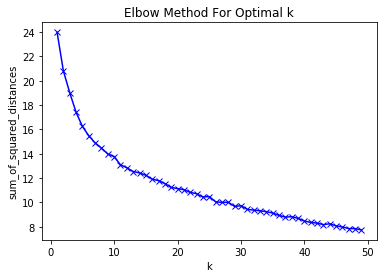

In [66]:
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')

Elbow method does not seem to help us to determine the optimal number of clusters. Let's use another method.

The Silhouette Method - The silhouette value measures how similar a point is to its own cluster (cohesion) compared to other clusters (separation). Source: Wikipedia

In [67]:
from sklearn.metrics import silhouette_score

sil = []
K_sil = range(2,50)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    print(k, end=' ')
    kmeans = KMeans(n_clusters = k).fit(nyc_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(nyc_grouped_clustering, labels, metric = 'euclidean'))

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 

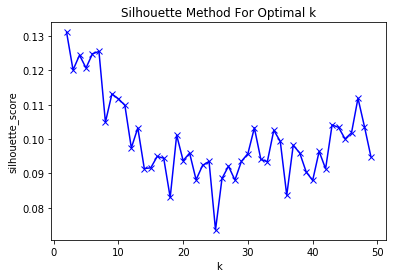

In [68]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

there is a peak at k = 2, k = 4 and k = 8. Two and four clusters will give a very broad classification of the venues

Let's set number of clusters = 8

In [69]:
# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=50).fit(nyc_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({6: 86, 1: 60, 4: 56, 2: 35, 0: 29, 5: 26, 3: 9, 7: 1})


Let's create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [70]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [71]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Allerton,Pizza Place,Caribbean Restaurant,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint
1,4,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant
2,4,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant
3,1,Arlington,Pizza Place,Fast Food Restaurant,Peruvian Restaurant,American Restaurant,Spanish Restaurant
4,2,Arrochar,Italian Restaurant,Chinese Restaurant,Steakhouse,Pizza Place,Mediterranean Restaurant


In [72]:
# merge neighborhoods_venues_sorted with nyc_data to add latitude/longitude for each neighborhood
nyc_merged = neighborhoods_venues_sorted.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
nyc_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,1,Allerton,Pizza Place,Caribbean Restaurant,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Bronx,40.865788,-73.859319
1,4,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,4,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
3,1,Arlington,Pizza Place,Fast Food Restaurant,Peruvian Restaurant,American Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
4,2,Arrochar,Italian Restaurant,Chinese Restaurant,Steakhouse,Pizza Place,Mediterranean Restaurant,Staten Island,40.596313,-74.067124


Finally, let's visualize the resulting clusters

In [73]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

# 5. Results

In [74]:
required_column_indices = [2,3,7]
required_column = [list(nyc_merged.columns.values)[i] for i in required_column_indices]
required_column_indices = [2,3,7]

Cluster 0

In [75]:
cluster_0 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 0, nyc_merged.columns[1:12]]
cluster_0.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Arverne,Chinese Restaurant,Taco Place,Caribbean Restaurant,American Restaurant,Pizza Place,Queens,40.589144,-73.791992
15,Bayswater,Chinese Restaurant,Pizza Place,Fried Chicken Joint,Caribbean Restaurant,American Restaurant,Queens,40.611322,-73.765968
20,Belle Harbor,Seafood Restaurant,Mexican Restaurant,Italian Restaurant,BBQ Joint,Chinese Restaurant,Queens,40.576156,-73.854018
23,Bensonhurst,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Italian Restaurant,Sushi Restaurant,Brooklyn,40.611009,-73.995180
61,College Point,Pizza Place,Chinese Restaurant,Asian Restaurant,Latin American Restaurant,Seafood Restaurant,Queens,40.784903,-73.843045


In [76]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Chinese Restaurant     21
Pizza Place             4
Indian Restaurant       1
Italian Restaurant      1
Seafood Restaurant      1
American Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      7
Pizza Place             5
Caribbean Restaurant    3
Italian Restaurant      2
Taco Place              2
Cantonese Restaurant    2
Fast Food Restaurant    2
Sushi Restaurant        1
American Restaurant     1
Korean Restaurant       1
Indian Restaurant       1
Mexican Restaurant      1
Seafood Restaurant      1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens           15
Brooklyn          6
Staten Island     6
Bronx             2
Name: Borough, dtype: int64
---------------------------------------------


Cluster 1

In [77]:
cluster_1 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 1, nyc_merged.columns[1:12]]
cluster_1.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Allerton,Pizza Place,Caribbean Restaurant,Mexican Restaurant,Fast Food Restaurant,Fried Chicken Joint,Bronx,40.865788,-73.859319
3,Arlington,Pizza Place,Fast Food Restaurant,Peruvian Restaurant,American Restaurant,Spanish Restaurant,Staten Island,40.635325,-74.165104
13,Baychester,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Caribbean Restaurant,Mexican Restaurant,Bronx,40.866858,-73.835798
17,Bedford Stuyvesant,Fast Food Restaurant,Pizza Place,French Restaurant,Mexican Restaurant,Fried Chicken Joint,Brooklyn,40.687232,-73.941785
30,Briarwood,Fast Food Restaurant,Fried Chicken Joint,Pizza Place,Chinese Restaurant,South American Restaurant,Queens,40.710935,-73.811748


In [78]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fast Food Restaurant               26
Pizza Place                        14
Chinese Restaurant                  7
Caribbean Restaurant                6
Latin American Restaurant           3
Southern / Soul Food Restaurant     1
Fried Chicken Joint                 1
New American Restaurant             1
Mexican Restaurant                  1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place                  18
Fast Food Restaurant         18
Mexican Restaurant            6
Fried Chicken Joint           6
Chinese Restaurant            5
Caribbean Restaurant          4
Latin American Restaurant     2
Steakhouse                    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Bronx            22
Brooklyn         16
Queens           11
Staten Island     6
Manhattan         5
Name: Borough, dtype: int64
---------------------------------------------


Cluster 2

In [79]:
cluster_2 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 2, nyc_merged.columns[1:12]]
cluster_2.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
4,Arrochar,Italian Restaurant,Chinese Restaurant,Steakhouse,Pizza Place,Mediterranean Restaurant,Staten Island,40.596313,-74.067124
7,Astoria Heights,Italian Restaurant,Pizza Place,Chinese Restaurant,Greek Restaurant,Sushi Restaurant,Queens,40.770317,-73.894680
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Queens,40.782843,-73.776802
12,Bay Terrace,Italian Restaurant,Pizza Place,Asian Restaurant,American Restaurant,Chinese Restaurant,Staten Island,40.553988,-74.139166
18,Beechhurst,Italian Restaurant,Pizza Place,Chinese Restaurant,Taco Place,Sushi Restaurant,Queens,40.792781,-73.804365


In [80]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant     33
Mexican Restaurant      1
Pizza Place             1
American Restaurant     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place             20
Chinese Restaurant       4
Fast Food Restaurant     3
Italian Restaurant       3
American Restaurant      2
Mexican Restaurant       2
Asian Restaurant         2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    17
Bronx             8
Queens            7
Manhattan         2
Brooklyn          2
Name: Borough, dtype: int64
---------------------------------------------


Cluster 3

In [81]:
cluster_3 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 3, nyc_merged.columns[1:12]]
cluster_3.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
29,Breezy Point,American Restaurant,Pizza Place,Whisky Bar,Halal Restaurant,Ethiopian Restaurant,Queens,40.557401,-73.925512
35,Brooklyn Heights,American Restaurant,Mexican Restaurant,French Restaurant,Pizza Place,Middle Eastern Restaurant,Brooklyn,40.695864,-73.993782
55,Clason Point,American Restaurant,Seafood Restaurant,South American Restaurant,Greek Restaurant,English Restaurant,Bronx,40.806551,-73.854144
74,Dumbo,American Restaurant,Pizza Place,Mexican Restaurant,Italian Restaurant,Ramen Restaurant,Brooklyn,40.703176,-73.988753
108,Fulton Ferry,American Restaurant,Pizza Place,Italian Restaurant,Mediterranean Restaurant,Seafood Restaurant,Brooklyn,40.703281,-73.995508


In [82]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant    7
Pizza Place            2
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Pizza Place            5
American Restaurant    2
Mexican Restaurant     1
Seafood Restaurant     1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Brooklyn         5
Staten Island    2
Bronx            1
Queens           1
Name: Borough, dtype: int64
---------------------------------------------


Cluster 4

In [83]:
cluster_4 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 4, nyc_merged.columns[1:12]]
cluster_4.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Annadale,Pizza Place,Sushi Restaurant,American Restaurant,Italian Restaurant,Japanese Restaurant,Staten Island,40.538114,-74.178549
2,Arden Heights,Pizza Place,American Restaurant,Italian Restaurant,Sushi Restaurant,Mexican Restaurant,Staten Island,40.549286,-74.185887
16,Bedford Park,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Fried Chicken Joint,Southern / Soul Food Restaurant,Bronx,40.870185,-73.885512
19,Bellaire,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Spanish Restaurant,Indian Restaurant,Queens,40.733014,-73.738892
21,Bellerose,Pizza Place,Chinese Restaurant,Indian Restaurant,Asian Restaurant,Halal Restaurant,Queens,40.728573,-73.720128


In [84]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Pizza Place                  51
Middle Eastern Restaurant     1
Mexican Restaurant            1
Asian Restaurant              1
Seafood Restaurant            1
Chinese Restaurant            1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant           18
Italian Restaurant            7
American Restaurant           6
Pizza Place                   5
Fast Food Restaurant          4
Sushi Restaurant              3
Mexican Restaurant            3
BBQ Joint                     3
Japanese Restaurant           2
Thai Restaurant               1
Russian Restaurant            1
Middle Eastern Restaurant     1
Greek Restaurant              1
Taco Place                    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    21
Queens           16
Brooklyn         10
Bronx             8
Manhattan         1
Name: Borough, dtype: int64
---------------------------------------------


In [ ]:
Cluster 5

In [85]:
cluster_5 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 5, nyc_merged.columns[1:12]]
cluster_5.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
36,Brookville,Fried Chicken Joint,Caribbean Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Queens,40.660003,-73.751753
37,Brownsville,Pizza Place,Chinese Restaurant,Caribbean Restaurant,Fried Chicken Joint,Seafood Restaurant,Brooklyn,40.663950,-73.910235
41,Cambria Heights,Caribbean Restaurant,Chinese Restaurant,Fried Chicken Joint,African Restaurant,Latin American Restaurant,Queens,40.692775,-73.735269
42,Canarsie,Caribbean Restaurant,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Mexican Restaurant,Brooklyn,40.635564,-73.902093
77,East Flatbush,Caribbean Restaurant,Fried Chicken Joint,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Brooklyn,40.641718,-73.936103


In [86]:
for col in required_column:
    print(cluster_5[col].value_counts(ascending = False))
    print("---------------------------------------------")

Caribbean Restaurant    20
Chinese Restaurant       3
Pizza Place              2
Fried Chicken Joint      1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Chinese Restaurant      11
Fast Food Restaurant     6
Pizza Place              4
Caribbean Restaurant     3
Fried Chicken Joint      2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Queens      11
Brooklyn     9
Bronx        6
Name: Borough, dtype: int64
---------------------------------------------


Cluster 6

In [87]:
cluster_6 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 6, nyc_merged.columns[1:12]]
cluster_6.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
6,Astoria,Fast Food Restaurant,Cajun / Creole Restaurant,Greek Restaurant,Vietnamese Restaurant,American Restaurant,Queens,40.768509,-73.915654
8,Auburndale,Korean Restaurant,Greek Restaurant,Pizza Place,American Restaurant,Italian Restaurant,Queens,40.761730,-73.791762
9,Bath Beach,Fast Food Restaurant,Chinese Restaurant,Sushi Restaurant,Japanese Restaurant,Malay Restaurant,Brooklyn,40.599519,-73.998752
10,Battery Park City,American Restaurant,Fast Food Restaurant,New American Restaurant,Pizza Place,French Restaurant,Manhattan,40.711932,-74.016869
11,Bay Ridge,Fast Food Restaurant,Pizza Place,Middle Eastern Restaurant,American Restaurant,Italian Restaurant,Brooklyn,40.625801,-74.030621


In [88]:
for col in required_column:
    print(cluster_6[col].value_counts(ascending = False))
    print("---------------------------------------------")

American Restaurant            18
Pizza Place                    17
Fast Food Restaurant           10
Korean Restaurant               8
Italian Restaurant              7
Mexican Restaurant              6
Japanese Restaurant             3
Seafood Restaurant              3
Thai Restaurant                 3
Sushi Restaurant                2
Ramen Restaurant                2
Spanish Restaurant              1
Indian Restaurant               1
French Restaurant               1
Dim Sum Restaurant              1
Eastern European Restaurant     1
Asian Restaurant                1
New American Restaurant         1
Chinese Restaurant              1
Turkish Restaurant              1
BBQ Joint                       1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
American Restaurant                22
Italian Restaurant                 17
Pizza Place                         8
New American Restaurant             6
Fast Food Restaurant                5
Chinese 

Cluster 7

In [90]:
cluster_7 = nyc_merged.loc[nyc_merged['Cluster Labels'] == 7, nyc_merged.columns[1:12]]
cluster_7.head(5)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
152,Lighthouse Hill,Italian Restaurant,Whisky Bar,Halal Restaurant,English Restaurant,Ethiopian Restaurant,Staten Island,40.576506,-74.137927


In [91]:
for col in required_column:
    print(cluster_7[col].value_counts(ascending = False))
    print("---------------------------------------------")

Italian Restaurant    1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Whisky Bar    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Staten Island    1
Name: Borough, dtype: int64
---------------------------------------------
